In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [68]:
df = pd.read_csv("../data/Processed_sunspot_without_missing.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [69]:
df

,Sunspot_Count
Date,
1818-01-08,65
1818-01-09,65
1818-01-10,65
1818-01-11,65
1818-01-12,65
...,...
2020-05-27,0
2020-05-28,0
2020-05-29,0


In [3]:
df['Sunspot_Count'] = df['Sunspot_Count'].replace(0, 1)


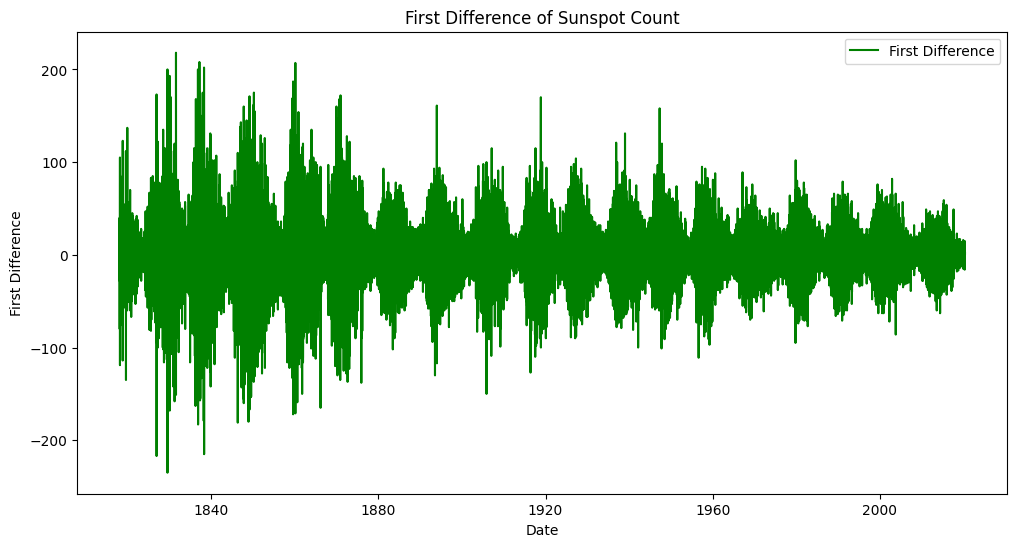

In [43]:
import matplotlib.pyplot as plt

# Calculate first difference
diff1 = df['Sunspot_Count'].diff()

plt.figure(figsize=(12, 6))
plt.plot(df.index, diff1, label='First Difference', color='green')
plt.xlabel("Date")
plt.ylabel("First Difference")
plt.title("First Difference of Sunspot Count")
plt.legend()
plt.show()


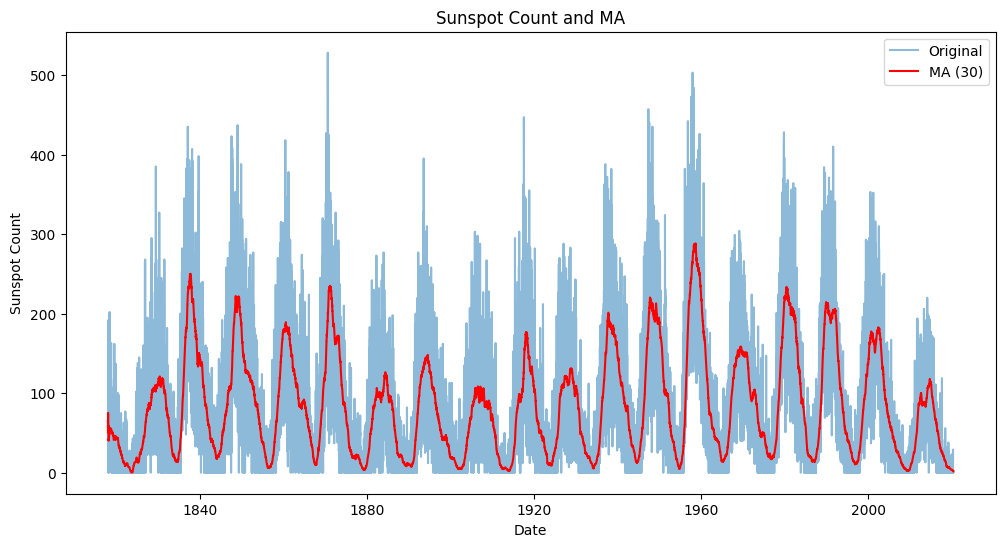

In [38]:
# 30일 이동평균 계산 (min_periods=1은 초기 부분도 계산)
df['Moving_Average'] = df['Sunspot_Count'].rolling(window=365, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sunspot_Count'], label='Original', alpha=0.5)
plt.plot(df.index, df['Moving_Average'], label='MA (30)', color='red')
plt.xlabel('Date')
plt.ylabel('Sunspot Count')
plt.title('Sunspot Count and MA')
plt.legend()
plt.show()


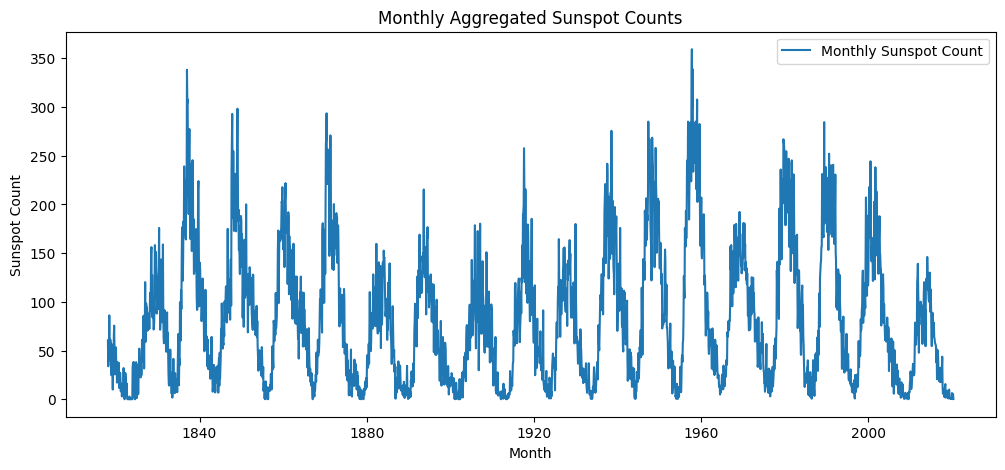

In [33]:
# 예시: 일별 데이터가 index에 날짜, 'Sunspot_Count' 컬럼에 값이 있다고 가정
df_monthly = df.resample('M').mean()  # 월별 평균 계산
# 또는 합계를 원한다면:
# df_monthly = df.resample('M').sum()

# 월별 데이터 플롯
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_monthly.index, df_monthly['Sunspot_Count'], marker='', label='Monthly Sunspot Count')
plt.title("Monthly Aggregated Sunspot Counts")
plt.xlabel("Month")
plt.ylabel("Sunspot Count")
plt.legend()
plt.show()


Total data points: 811, Training: 648, Testing: 163
                                     SARIMAX Results                                      
Dep. Variable:                          log_birth   No. Observations:                  648
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 44)   Log Likelihood                -559.635
Date:                            Mon, 17 Mar 2025   AIC                           1127.271
Time:                                    07:16:42   BIC                           1144.878
Sample:                                01-31-1818   HQIC                          1134.124
                                     - 10-31-1979                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0485      0.065      0.746      0.456      -0

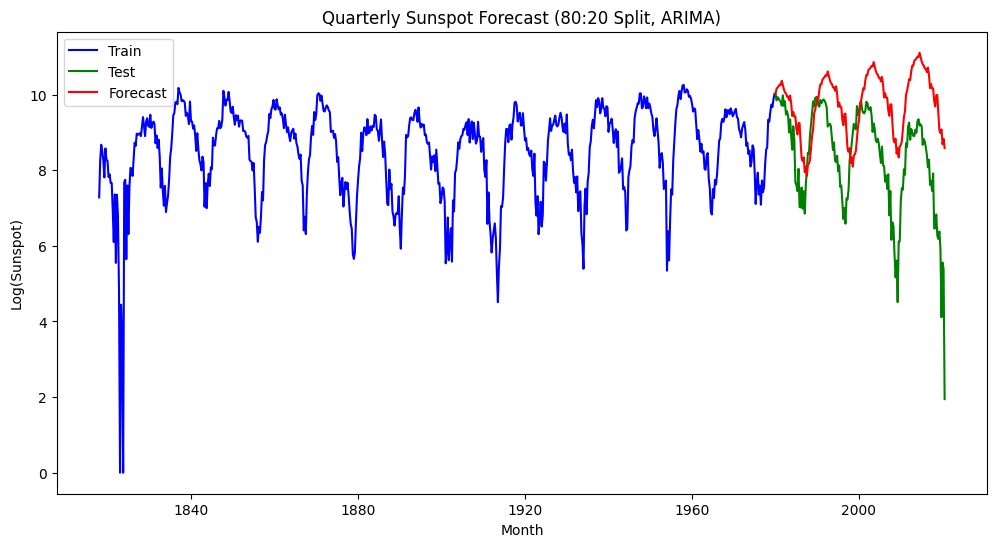

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------
# 1. Aggregate daily ori into monthly ori using sum (for count ori)
#    (Assumes df.index is datetime and 'birth_counts' column exists)
# ----------------------------
df_monthly = df.resample('3M').sum()

# ----------------------------
# 2. Apply log transformation to stabilize variance
# ----------------------------
df_monthly['log_birth'] = np.log1p(df_monthly['Sunspot_Count'])

# For modeling, use the log-transformed series
series = df_monthly['log_birth']

# ----------------------------
# 3. Split ori into training (80%) and testing (20%)
# ----------------------------
n_total = len(series.dropna())
split_index = int(n_total * 0.8)
train = series.dropna().iloc[:split_index]
test = series.dropna().iloc[split_index:]
horizon = len(test)
print(f"Total ori points: {n_total}, Training: {len(train)}, Testing: {len(test)}")

# ----------------------------
# 4. Fit an ARIMA model using SARIMAX
#    (For this example, we assume the series has a weak trend and annual seasonality.
#     Here, seasonal_order=(0,1,1,12) is used as an example.)
# ----------------------------
start_time = time.time()  # 시작 시간 측정

model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,1,44))
model_fit = model.fit(disp=False)
print(model_fit.summary())

# ----------------------------
# 5. Forecast for the test period
# ----------------------------
forecast = model_fit.forecast(steps=horizon)
forecast_series = pd.Series(forecast, index=test.index)

end_time = time.time()  # 종료 시간 측정
exec_time = end_time - start_time

# ----------------------------
# 6. Calculate Evaluation Metrics
# ----------------------------

# MAE & RMSE using scikit-learn functions
mae = mean_absolute_error(test, forecast_series)
rmse = np.sqrt(mean_squared_error(test, forecast_series))

# sMAPE 계산
def calc_smape(actual, forecast, eps=1e-8):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast) + eps))

smape = calc_smape(test.values, forecast_series.values)

# MASE 계산: 훈련 데이터의 naïve forecast 오차의 평균으로 스케일링
naive_forecast = train.shift(1)
scale = np.mean(np.abs(train.dropna() - naive_forecast.dropna()))
mase = mae / (scale + 1e-8)  # 0으로 나누는 경우 방지

# ----------------------------
# 7. Save the metrics to CSV
# ----------------------------
metrics_dict = {
    'sMAPE': [smape],
    'MASE': [mase],
    'MAE': [mae],
    'RMSE': [rmse],
    'Execution Time': [exec_time]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.to_csv("forecast_evaluation_metrics.csv", index=False)
print("Evaluation metrics saved to 'forecast_evaluation_metrics.csv'.")

# ----------------------------
# 8. Visualize the results
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red', linestyle='-')
plt.xlabel("Month")
plt.ylabel("Log(Sunspot)")
plt.title("Quarterly Sunspot Forecast (80:20 Split, ARIMA)")
plt.legend()
plt.show()


In [13]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

def run_stationarity_tests(series):
    print("=== ADF 검정 결과 ===")
    adf_result = adfuller(series, autolag='AIC')
    adf_stat, adf_p, adf_lags, adf_nobs, adf_crit, adf_icbest = adf_result
    print(f"검정 통계량: {adf_stat:.4f}")
    print(f"p-value: {adf_p:.4f}")
    print(f"사용된 lag 수: {adf_lags}")
    print(f"관측치 수: {adf_nobs}")
    print("임계값:")
    for key, value in adf_crit.items():
        print(f"  {key} 유의수준: {value:.4f}")
        
    # ADF 검정의 귀무가설은 "단위근이 존재하여 시계열이 비정상이다"입니다.
    # 검정 통계량이 임계값보다 작으면 귀무가설을 기각하여 정상성을 인정함.
    if adf_stat < adf_crit["5%"]:
        adf_conclusion = "정상"
        print("=> ADF 검정 결과: 귀무가설(비정상)을 기각합니다. 시계열은 정상입니다.\n")
    else:
        adf_conclusion = "비정상"
        print("=> ADF 검정 결과: 귀무가설(비정상)을 기각하지 못했습니다. 시계열은 비정상입니다.\n")
    
    print("=== KPSS 검정 결과 ===")
    kpss_result = kpss(series, regression='c', nlags="auto")
    kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss_result
    print(f"검정 통계량: {kpss_stat:.4f}")
    print(f"p-value: {kpss_p:.4f}")
    print(f"사용된 lag 수: {kpss_lags}")
    print("임계값:")
    for key, value in kpss_crit.items():
        print(f"  {key} 유의수준: {value:.4f}")
        
    # KPSS 검정의 귀무가설은 "시계열이 정상이다"입니다.
    # 검정 통계량이 각 유의수준의 임계값보다 크면 귀무가설을 기각하여 비정상으로 판단합니다.
    kpss_conclusion = "정상"
    for level, crit in kpss_crit.items():
        if kpss_stat > crit:
            kpss_conclusion = "비정상"
            print(f"{level} 유의수준: KPSS 검정 통계량이 임계값보다 큽니다. (비정상)")
        else:
            print(f"{level} 유의수준: KPSS 검정 통계량이 임계값 이하입니다. (정상)")
    
    print("\n=== 종합 결과 ===")
    print(f"ADF 검정 결론: {adf_conclusion}")
    print(f"KPSS 검정 결론: {kpss_conclusion}")
    
    if adf_conclusion == "정상" and kpss_conclusion == "정상":
        print("=> 최종 결론: 시계열은 정상입니다.")
    elif adf_conclusion == "비정상" and kpss_conclusion == "비정상":
        print("=> 최종 결론: 시계열은 비정상입니다.")
    else:
        print("=> 최종 결론: 검정 결과가 상반됩니다. 추가 분석이 필요합니다.")

# 예시 사용:
series = df
run_stationarity_tests(series)


=== ADF 검정 결과 ===
검정 통계량: -7.8658
p-value: 0.0000
사용된 lag 수: 62
관측치 수: 73861
임계값:
  1% 유의수준: -3.4304
  5% 유의수준: -2.8616
  10% 유의수준: -2.5668
=> ADF 검정 결과: 귀무가설(비정상)을 기각합니다. 시계열은 정상입니다.

=== KPSS 검정 결과 ===
검정 통계량: 0.5889
p-value: 0.0236
사용된 lag 수: 155
임계값:
  10% 유의수준: 0.3470
  5% 유의수준: 0.4630
  2.5% 유의수준: 0.5740
  1% 유의수준: 0.7390
10% 유의수준: KPSS 검정 통계량이 임계값보다 큽니다. (비정상)
5% 유의수준: KPSS 검정 통계량이 임계값보다 큽니다. (비정상)
2.5% 유의수준: KPSS 검정 통계량이 임계값보다 큽니다. (비정상)
1% 유의수준: KPSS 검정 통계량이 임계값 이하입니다. (정상)

=== 종합 결과 ===
ADF 검정 결론: 정상
KPSS 검정 결론: 비정상
=> 최종 결론: 검정 결과가 상반됩니다. 추가 분석이 필요합니다.


In [30]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss

# 원본 시계열 준비 (NaN 보간)
series = df['Sunspot_Count']
series = series.interpolate()

# 1차 차분 수행 (첫 번째 값은 NaN이므로 제거)
diff1 = series.diff().dropna()

print("===== 1차 차분 후 시계열 =====")
print(diff1.head())

# ----------------------------
# Augmented Dickey-Fuller (ADF) 테스트
# ----------------------------
adf_result = adfuller(diff1)
adf_stat = adf_result[0]
adf_pvalue = adf_result[1]

print("\nADF Test Results:")
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value: {adf_pvalue:.4f}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# ADF 해석: p-value < 0.05이면 귀무가설(단위근 존재)을 기각하므로 정상(stationary)하다고 판단
if adf_pvalue < 0.05:
    print("ADF Test: p-value가 0.05보다 작으므로 1차 차분 시계열은 정상입니다.")
else:
    print("ADF Test: p-value가 0.05보다 크므로 1차 차분 시계열은 비정상입니다.")

# ----------------------------
# KPSS 테스트 (regression='c'는 상수 항을 가진 안정적인 시계열 가정)
# ----------------------------
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print("\nKPSS Test Results:")
    print(f"KPSS Statistic: {statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"num lags: {n_lags}")
    for key, value in critical_values.items():
        print(f"Critical Value ({key}): {value:.4f}")
    return p_value

kpss_pvalue = kpss_test(diff1, regression='c')

# KPSS 해석: KPSS의 귀무가설은 정상(stationary)임. p-value < 0.05이면 귀무가설을 기각하므로 비정상으로 판단.
if kpss_pvalue < 0.05:
    print("KPSS Test: p-value가 0.05보다 작으므로 1차 차분 시계열은 비정상입니다.")
else:
    print("KPSS Test: p-value가 0.05보다 크므로 1차 차분 시계열은 정상입니다.")


===== 1차 차분 후 시계열 =====
Date
1818-01-09     0.0
1818-01-10     0.0
1818-01-11     0.0
1818-01-12     0.0
1818-01-13   -28.0
Name: Sunspot_Count, dtype: float64

ADF Test Results:
ADF Statistic: -49.6708
p-value: 0.0000
Critical Value (1%): -3.4304
Critical Value (5%): -2.8616
Critical Value (10%): -2.5668
ADF Test: p-value가 0.05보다 작으므로 1차 차분 시계열은 정상입니다.

KPSS Test Results:
KPSS Statistic: 0.0107
p-value: 0.1000
num lags: 1009
Critical Value (10%): 0.3470
Critical Value (5%): 0.4630
Critical Value (2.5%): 0.5740
Critical Value (1%): 0.7390
KPSS Test: p-value가 0.05보다 크므로 1차 차분 시계열은 정상입니다.


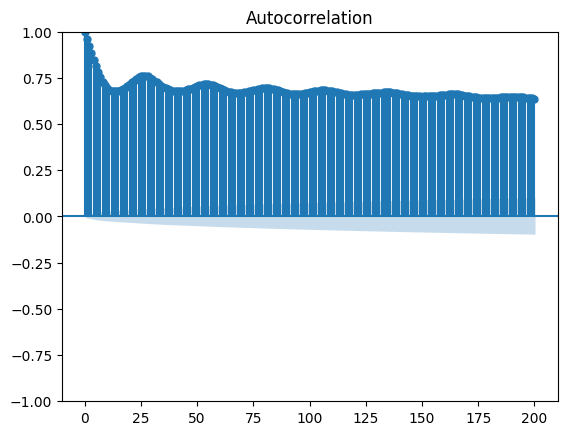

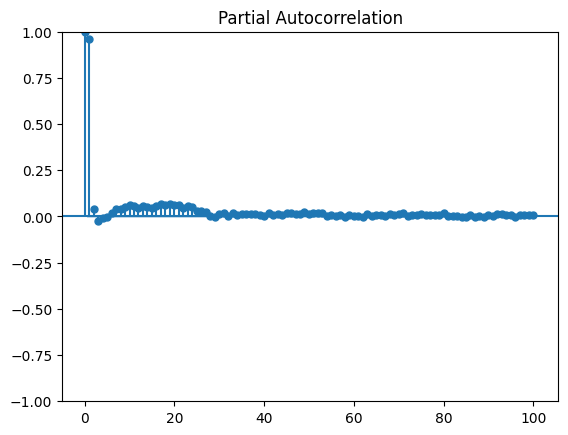

In [37]:
plot_acf(df['Sunspot_Count'], lags=200)
plt.show()

plot_pacf(df['Sunspot_Count'], lags=100)
plt.show()


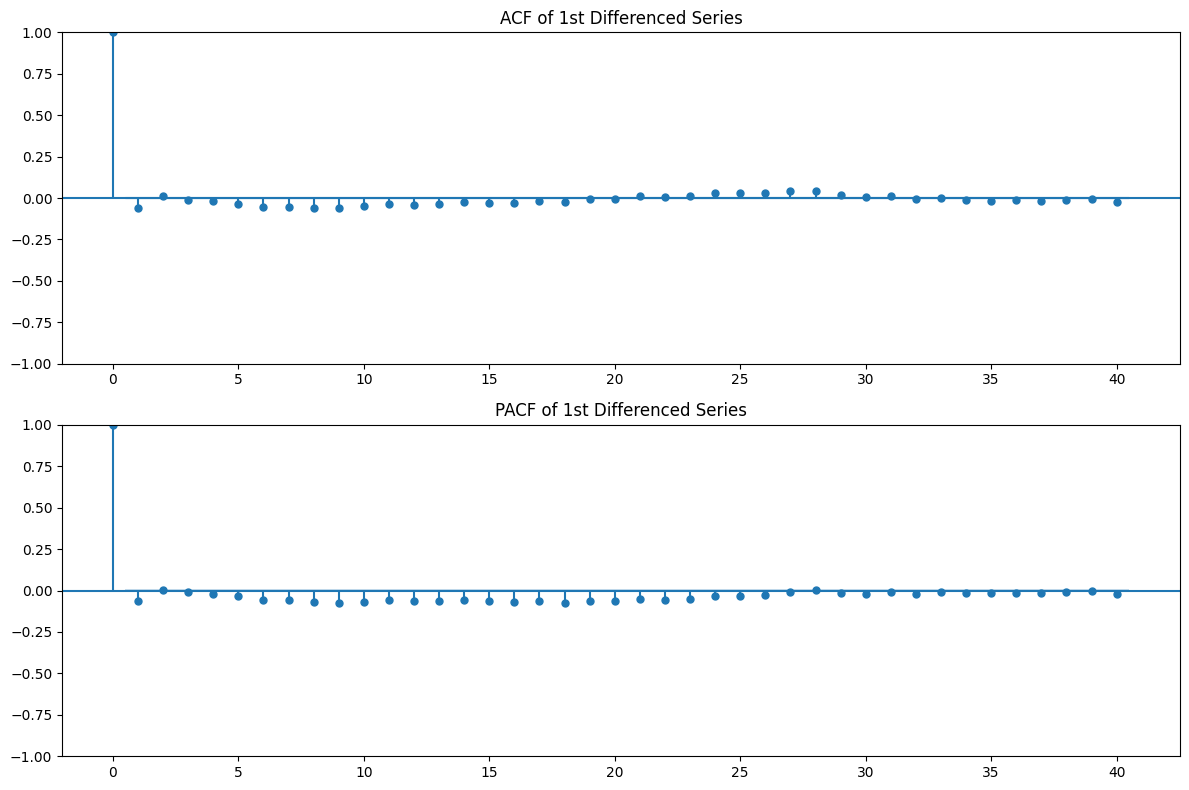

In [31]:
# 원본 시계열 준비 (예: df에 'Sunspot_Count' 컬럼이 있다고 가정)
series = df['Sunspot_Count'].interpolate()

# 1차 차분 수행 (첫 번째 값은 NaN이므로 drop)
diff1 = series.diff().dropna()

# ACF와 PACF 플롯 그리기
plt.figure(figsize=(12, 8))

plt.subplot(211)
plot_acf(diff1, lags=40, ax=plt.gca())
plt.title("ACF of 1st Differenced Series")

plt.subplot(212)
plot_pacf(diff1, lags=40, ax=plt.gca(), method='ywm')  # 'ywm' 방식 사용
plt.title("PACF of 1st Differenced Series")

plt.tight_layout()
plt.show()


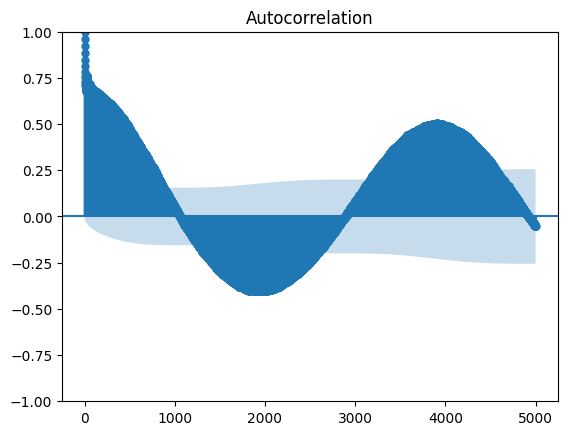

In [8]:
# ACF 플롯을 통해 반복되는 피크를 확인 (예: 365일마다 피크가 나타난다면 계절 주기는 365일)
plot_acf(df['Sunspot_Count'], lags=5000)
plt.show()


In [80]:
df

,Sunspot_Count
Date,
1818-01-08,65
1818-01-09,65
1818-01-10,65
1818-01-11,65
1818-01-12,65
...,...
2020-05-27,0
2020-05-28,0
2020-05-29,0


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------
# Model Libraries
# ----------------------------
# ARIMA: SARIMAX from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
# SES and ETS: SimpleExpSmoothing, ExponentialSmoothing from statsmodels
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
# Prophet
from prophet import Prophet
# TBATS from tbats package
try:
    from tbats import TBATS
except Exception as e:
    print("TBATS 라이브러리가 설치되어 있지 않습니다.", e)
# Theta model from statsforecast
try:
    from statsforecast.models import Theta
    from statsforecast import StatsForecast
except Exception as e:
    print("Theta 모델 관련 라이브러리가 설치되어 있지 않습니다.", e)

# ----------------------------
# 1. Data Preparation: Resample daily ori into monthly ori using mean
#    (Assumes df.index is a datetime index and 'Sunspot_Count' column exists)
# ----------------------------
df_monthly = df.resample('M').mean()

# ----------------------------
# 2. Log Transformation
# ----------------------------
# Use log1p to avoid issues with zeros
df_monthly['log_sunspot'] = np.log1p(df_monthly['Sunspot_Count'])

# For modeling, use the log-transformed series
series = df_monthly['log_sunspot']

# ----------------------------
# 3. Split ori into training (80%) and testing (20%)
# ----------------------------
n_total = len(series.dropna())
split_index = int(n_total * 0.8)
train = series.dropna().iloc[:split_index]
test = series.dropna().iloc[split_index:]
horizon = len(test)
print(f"Total ori points: {n_total}, Training: {len(train)}, Testing: {len(test)}")

# For evaluation on original scale, we'll use np.expm1 to invert the log transformation.
actual_orig = np.expm1(test)

# For MASE: Calculate scale on training ori (naïve forecast = previous value)
train_orig = np.expm1(train)
naive_forecast = train_orig.shift(1)
scale = np.mean(np.abs(train_orig.dropna() - naive_forecast.dropna()))

# ----------------------------
# 4. Define Evaluation Metric Functions
# ----------------------------
def calc_smape(actual, forecast, eps=1e-8):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast) + eps))

def calc_mase(actual, forecast, scale, eps=1e-8):
    mae = mean_absolute_error(actual, forecast)
    return mae / (scale + eps)

# Dictionary to store results for each model
results = []

# ----------------------------
# 5. Model 1: ARIMA (Using SARIMAX)
#    - Since we assume no strong trend after log transformation, we use ARIMA with d=0 (i.e. ARMA)
#    - Seasonal period: 11-year cycle in monthly ori -> 11*12 = 132
# ----------------------------
start = time.time()
model_arima = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,132))
fit_arima = model_arima.fit(disp=False)
forecast_arima = fit_arima.forecast(steps=horizon)
end = time.time()
exec_time = end - start

forecast_arima_log = pd.Series(forecast_arima, index=test.index)
forecast_arima_orig = np.expm1(forecast_arima_log)

mae_arima = mean_absolute_error(actual_orig, forecast_arima_orig)
rmse_arima = np.sqrt(mean_squared_error(actual_orig, forecast_arima_orig))
smape_arima = calc_smape(actual_orig.values, forecast_arima_orig.values)
mase_arima = calc_mase(actual_orig, forecast_arima_orig, scale)

results.append({
    'Model': 'ARIMA',
    'sMAPE': smape_arima,
    'MASE': mase_arima,
    'MAE': mae_arima,
    'RMSE': rmse_arima,
    'Execution Time': exec_time
})
print("ARIMA completed.")

# ----------------------------
# 6. Model 2: SES (Simple Exponential Smoothing)
# ----------------------------
start = time.time()
model_ses = SimpleExpSmoothing(train).fit(optimized=True)
forecast_ses = model_ses.forecast(steps=horizon)
end = time.time()
exec_time = end - start

forecast_ses_log = pd.Series(forecast_ses, index=test.index)
forecast_ses_orig = np.expm1(forecast_ses_log)

mae_ses = mean_absolute_error(actual_orig, forecast_ses_orig)
rmse_ses = np.sqrt(mean_squared_error(actual_orig, forecast_ses_orig))
smape_ses = calc_smape(actual_orig.values, forecast_ses_orig.values)
mase_ses = calc_mase(actual_orig, forecast_ses_orig, scale)

results.append({
    'Model': 'SES',
    'sMAPE': smape_ses,
    'MASE': mase_ses,
    'MAE': mae_ses,
    'RMSE': rmse_ses,
    'Execution Time': exec_time
})
print("SES completed.")

# ----------------------------
# 7. Model 3: Theta Model (using statsforecast)
# ----------------------------
try:
    start = time.time()
    # Prepare DataFrame for statsforecast: columns: ds, y, unique_id
    train_df = pd.DataFrame({'ds': train.index, 'y': train.values, 'unique_id': 'series'})
    sf = StatsForecast(train_df, models=[Theta()], freq='M')
    forecast_df = sf.forecast(horizon, train_df)
    # forecast_df has a column named 'Theta'
    forecast_theta_log = forecast_df['Theta']
    end = time.time()
    exec_time = end - start

    forecast_theta_orig = np.expm1(forecast_theta_log)
    
    mae_theta = mean_absolute_error(actual_orig, forecast_theta_orig)
    rmse_theta = np.sqrt(mean_squared_error(actual_orig, forecast_theta_orig))
    smape_theta = calc_smape(actual_orig.values, forecast_theta_orig.values)
    mase_theta = calc_mase(actual_orig, forecast_theta_orig, scale)
    
    results.append({
        'Model': 'Theta',
        'sMAPE': smape_theta,
        'MASE': mase_theta,
        'MAE': mae_theta,
        'RMSE': rmse_theta,
        'Execution Time': exec_time
    })
    print("Theta completed.")
except Exception as e:
    print("Theta model error:", e)

# ----------------------------
# 8. Model 4: TBATS Model (using tbats package)
# ----------------------------
try:
    start = time.time()
    # For monthly ori with an 11-year cycle, seasonal_periods = 132
    estimator = TBATS(seasonal_periods=[132])
    model_tbats = estimator.fit(train.values)
    forecast_tbats = model_tbats.forecast(steps=horizon)
    forecast_tbats_log = pd.Series(forecast_tbats, index=test.index)
    end = time.time()
    exec_time = end - start

    forecast_tbats_orig = np.expm1(forecast_tbats_log)
    
    mae_tbats = mean_absolute_error(actual_orig, forecast_tbats_orig)
    rmse_tbats = np.sqrt(mean_squared_error(actual_orig, forecast_tbats_orig))
    smape_tbats = calc_smape(actual_orig.values, forecast_tbats_orig.values)
    mase_tbats = calc_mase(actual_orig, forecast_tbats_orig, scale)
    
    results.append({
        'Model': 'TBATS',
        'sMAPE': smape_tbats,
        'MASE': mase_tbats,
        'MAE': mae_tbats,
        'RMSE': rmse_tbats,
        'Execution Time': exec_time
    })
    print("TBATS completed.")
except Exception as e:
    print("TBATS model error:", e)

# ----------------------------
# 9. Model 5: ETS Model (using ExponentialSmoothing)
#    Assume no trend (trend=None) and additive seasonality with seasonal_periods=132
# ----------------------------
start = time.time()
model_ets = ExponentialSmoothing(train, trend=None, seasonal='add', seasonal_periods=132).fit(optimized=True)
forecast_ets = model_ets.forecast(steps=horizon)
end = time.time()
exec_time = end - start

forecast_ets_log = pd.Series(forecast_ets, index=test.index)
forecast_ets_orig = np.expm1(forecast_ets_log)

mae_ets = mean_absolute_error(actual_orig, forecast_ets_orig)
rmse_ets = np.sqrt(mean_squared_error(actual_orig, forecast_ets_orig))
smape_ets = calc_smape(actual_orig.values, forecast_ets_orig.values)
mase_ets = calc_mase(actual_orig, forecast_ets_orig, scale)

results.append({
    'Model': 'ETS',
    'sMAPE': smape_ets,
    'MASE': mase_ets,
    'MAE': mae_ets,
    'RMSE': rmse_ets,
    'Execution Time': exec_time
})
print("ETS completed.")

# ----------------------------
# 10. Model 6: Prophet Model
# ----------------------------
try:
    start = time.time()
    train_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
    model_prophet = Prophet()
    model_prophet.fit(train_prophet)
    future = model_prophet.make_future_dataframe(periods=horizon, freq='M', include_history=False)
    forecast_prophet = model_prophet.predict(future)
    forecast_prophet_log = pd.Series(forecast_prophet['yhat'].values, index=test.index)
    end = time.time()
    exec_time = end - start

    forecast_prophet_orig = np.expm1(forecast_prophet_log)
    
    mae_prophet = mean_absolute_error(actual_orig, forecast_prophet_orig)
    rmse_prophet = np.sqrt(mean_squared_error(actual_orig, forecast_prophet_orig))
    smape_prophet = calc_smape(actual_orig.values, forecast_prophet_orig.values)
    mase_prophet = calc_mase(actual_orig, forecast_prophet_orig, scale)
    
    results.append({
        'Model': 'Prophet',
        'sMAPE': smape_prophet,
        'MASE': mase_prophet,
        'MAE': mae_prophet,
        'RMSE': rmse_prophet,
        'Execution Time': exec_time
    })
    print("Prophet completed.")
except Exception as e:
    print("Prophet model error:", e)

# ----------------------------
# 11. Save the evaluation metrics to CSV
# ----------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("sunspot_forecast_evaluation_metrics.csv", index=False)
print("Evaluation metrics saved to 'sunspot_forecast_evaluation_metrics.csv'.")
print(results_df)


Importing plotly failed. Interactive plots will not work.


Total data points: 2429, Training: 1943, Testing: 486
ARIMA completed.
SES completed.
Theta model error: _StatsForecast.__init__() got multiple values for argument 'models'
TBATS completed.
ETS completed.


07:12:30 - cmdstanpy - INFO - Chain [1] start processing
07:12:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet completed.
Evaluation metrics saved to 'sunspot_forecast_evaluation_metrics.csv'.
     Model       sMAPE      MASE         MAE        RMSE  Execution Time
0    ARIMA   84.272539  2.839443   56.287188   72.361324      220.107888
1      SES  112.529145  8.430291  167.116393  181.541918        0.043002
2    TBATS   99.300069  4.637240   91.925506  105.163107       83.100039
3      ETS  117.162286  9.416410  186.664540  222.381961        0.354578
4  Prophet   86.352606  3.529871   69.973767   80.359543        0.511344
